**Pose Estimation**</br>
We are given:
- the camera model 
- object mesh model
- one image of the object

Goal: estimate the object orientation and position. </br>
Such a pose estimation problem can be formulated as an optimization problem, where the object pose is fitted to the image observation.

**Pose Tracking**</br>
Assume we already estimated the object pose in the time slots 1, 2,..., up to t-1. </br>
We are given: one image observation of the object at time t.</br>
Goal: estimate the object pose at the time slot t.

### Differentiable Rendering
**Rendering** is the process of projecting 3D physical models (a mesh model for the object, or a camera model) into 2D images. It is an imitation of the physical process of image formation and in many cases image formation itself is differentiable. However, there are cases where the pixel color is not a smooth function of the position. For example, it can happen at the occlusion boundaries. When we use conventional rendering algorithms, information about local gradients is lost due to discretization. 

Rendering pipeline: (1) Rasterization and (2) Shading

**Rasterization** is a step of rendering where for each pixel on the imaging plane, we find the most relevant mesh face (or decide that no relevant mesh face can be found). In conventional rasterization, for each pixel, we generate a ray from the camera center going through the pixel on the imaging plane and rasterizer returns only the mesh face that is nearest to the camera.

**Shading** is a process of determining pixel colors for the mesh faces returned from the 1st step. Shading is usually based on a specific shading algorithms (such as the Lambertian model or Phong model).

In the rendering pipeline, the 1st step (the step of choosing the mesh to render) is a non-differentiable process, because it is mathematically modeled as a step function. Differentiable rendering has been discussed in the computer vision community for decades.

The **differentiable rendering** implemented in PyTorch3D is based on *Soft Rasterizer* proposed by Liu, Li, Chen, and Li ([arXiv:1904.01786](https://arxiv.org/abs/1904.01786)). The main idea is that, on the rasterization step, instead of returning only one relevant mesh face, all the mesh faces, such that the distance of the mesh face to the ray is within a certain threshold, are found, and then the probability map for each mesh face is calculated (the pixel color is determined by the weighted averages of the shading results of all the mesh faces returned by the rasterizer).

The list of parameters to control differentiable rendering in PyTorch3D:
- RasterizationSettings.blur_radius - the treshold for the distance of the mesh face to the ray;
- RasterizationSettings.faces_per_pixel - the maximum number of faces to be returned by rasterizor
- BlendParams.sigma - hyperparameter used  in sigmoid functions to calculate the probability map
- BlendParams.gamma - hyperparameter that is used calculate weights of mesh faces (to inverse depth of mesh faces)

### Object Pose Estimation

We are given:
- the camera model 
- object mesh model
- one image of the object

Goal: estimate the object orientation and position at the moments when the image was taken. </br>
Such a pose estimation problem can be formulated as an optimization problem, where the object pose is fitted to the image observation.

Because it is cumbersome to rotate and move the meshes, we choose instead to fix the orientations and locations of the meshes and optimize the orientations and locations of the cameras. By assuming that the camera orientations are always pointing toward the meshes, we can further simplify the problem, such that all we need to optimize is the camera locations. Thus, we formulate our optimization problem, such that the optimization variables will be the camera locations.

In [1]:
# Importing libraries and packages 
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

#!pip install scikit-image
from skimage import img_as_ubyte 

from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [2]:
# Defining PyTorch device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be more slowly")

In [3]:
# Setting directory that contains mesh files
data_dir = "data/"

# Setting output directory, to store rendered images for each optimization iteration
output_dir = "output/"

In [5]:
# Loading the mesh model
verts, faces_idx, _ = load_obj(data_dir+"teapot.obj")
faces = faces_idx.verts_idx

# Creating an all-one tensor for textures (material colors), because the mesh model does not come with textures
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Obtaining a mesh model with textures
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

In [6]:
# Defining camera model
cameras = FoVPerspectiveCameras(device=device)

In [13]:
# Defining a differentiable renderer - silhouette_renderer
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)

silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

In [14]:
# Defining phong_renderer (will be used for visualization of the optimization process)
# !!! it is not a differentiable renderer
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

In [15]:
# Defining a camera location and compute the corresponding rotation, R, and displacement, T, of the camera. 
# This rotation and displacement are the target camera position

distance = 3
elevation = 50.0
azimuth = 0.0

R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

In [16]:
# Generate an image (image_ref) from this camera position and storing it
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_silhouette.png'))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_rgb.png'))
plt.close()

In [18]:
# Define a Model class that is derived from torch

class Model(nn.Module):
    
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Making the optimization variables become the model parameters
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device)) 

    def forward(self): # renders a silhouette image from the current camera position and computes a loss function 
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [19]:
# Creating an instance of the class 
model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Defining an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Before running any optimization, we will render an image to show the starting camera position
_, image_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, 'starting_silhouette.png'))
plt.close()

In [20]:
# Running optimization iterations

for i in range(0, 200):
    
    if i%20 == 0: # printing out every 20th step
        print('i = ', i)

    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    if loss.item() < 500:
        break

    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)

    plt.figure()
    plt.imshow(image[..., :3])
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'fitting_' + str(i) + '.png'))
    plt.close()

print('Finished')

i =  0
i =  20
i =  40
i =  60
Finished


### Object Pose Estimation for both Silhouette Fitting and Texture Fitting

In [1]:
# Importing Libraries and Packages
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

from pytorch3d.io import load_objs_as_meshes

from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights,
    SoftPhongShader
)

In [2]:
# Defining PyTorch device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be more slowly")

In [3]:
# Setting directory that contains mesh files
data_dir = "data/"

# Setting output directory, to store rendered images for each optimization iteration
output_dir = "output/2/"

In [4]:
# Loading a mesh model of a toy cow
obj_filename = data_dir+"cow_mesh/cow.obj"
cow_mesh = load_objs_as_meshes([obj_filename], device=device)

In [5]:
# Defining cameras and light sources
cameras = FoVPerspectiveCameras(device=device)
lights = PointLights(device=device, location=((2.0, 2.0,-2.0),))

In [6]:
# Defining a differentiable renderer - silhouette_renderer
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)

renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

In [7]:
# Creating another differentiable renderer, mainly used for rendering RGB images
sigma = 1e-4

raster_settings_soft = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device,
        cameras=cameras,
        lights=lights)
)

In [8]:
# Create a phong_renderer renderer to use for visualization (create sharp images) 
# because the preceding differentiable renders tend to create blurry images

raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

In [9]:
# Defining a camera location and compute the corresponding rotation, R, and displacement, T, of the camera. 
# This rotation and displacement are the target camera position
distance = 3
elevation = 50.0
azimuth = 0.0

R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

In [10]:
# Creating the observed images and save them to target_silhouette.png and target_rgb.png
silhouette = renderer_silhouette(meshes_world=cow_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=cow_mesh, R=R, T=T)
silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_silhouette.png'))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_rgb.png'))
plt.close()

In [11]:
# Re-defining Model class
# Now, will render both the alpha channel image and the RGB images 
# and compare them with the observed images. 

class Model(nn.Module):
    def __init__(self, meshes, renderer_silhouette, renderer_textured, image_ref, weight_silhouette, weight_texture):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer_silhouette = renderer_silhouette
        self.renderer_textured = renderer_textured

        self.weight_silhouette = weight_silhouette
        self.weight_texture = weight_texture

        image_ref_silhouette = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref_silhouette', image_ref_silhouette)

        image_ref_textured = torch.from_numpy((image_ref[..., :3]).astype(np.float32))
        self.register_buffer('image_ref_textured', image_ref_textured)

        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image_silhouette = self.renderer_silhouette(meshes_world=self.meshes.clone(), R=R, T=T)
        image_textured = self.renderer_textured(meshes_world=self.meshes.clone(), R=R, T=T)

        loss_silhouette = torch.sum((image_silhouette[..., 3] - self.image_ref_silhouette) ** 2)
        loss_texture = torch.sum((image_textured[..., :3] - self.image_ref_textured) ** 2)

        loss = self.weight_silhouette * loss_silhouette + self.weight_texture * loss_texture
        return loss, image_silhouette, image_textured

In [ ]:
# Creating an instance of the Model class and an optimizer
model = Model(meshes=cow_mesh, 
              renderer_silhouette=renderer_silhouette, 
              renderer_textured = renderer_textured,
              image_ref=image_ref, 
              weight_silhouette=1.0, 
              weight_texture=0.1).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.05) 

### BETTER: 
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.25)  # 2/

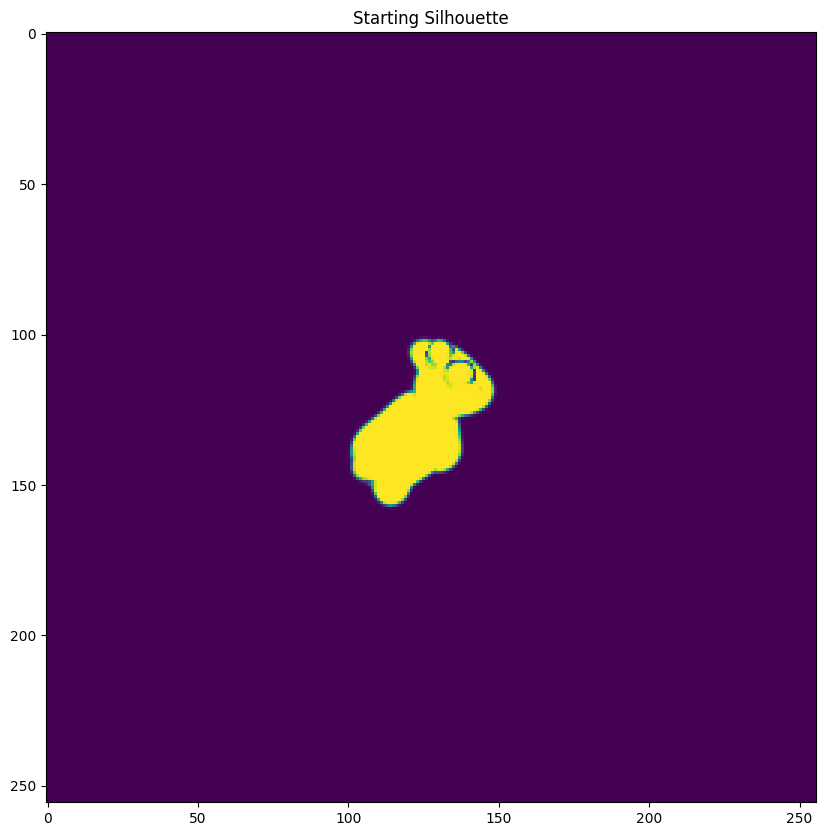

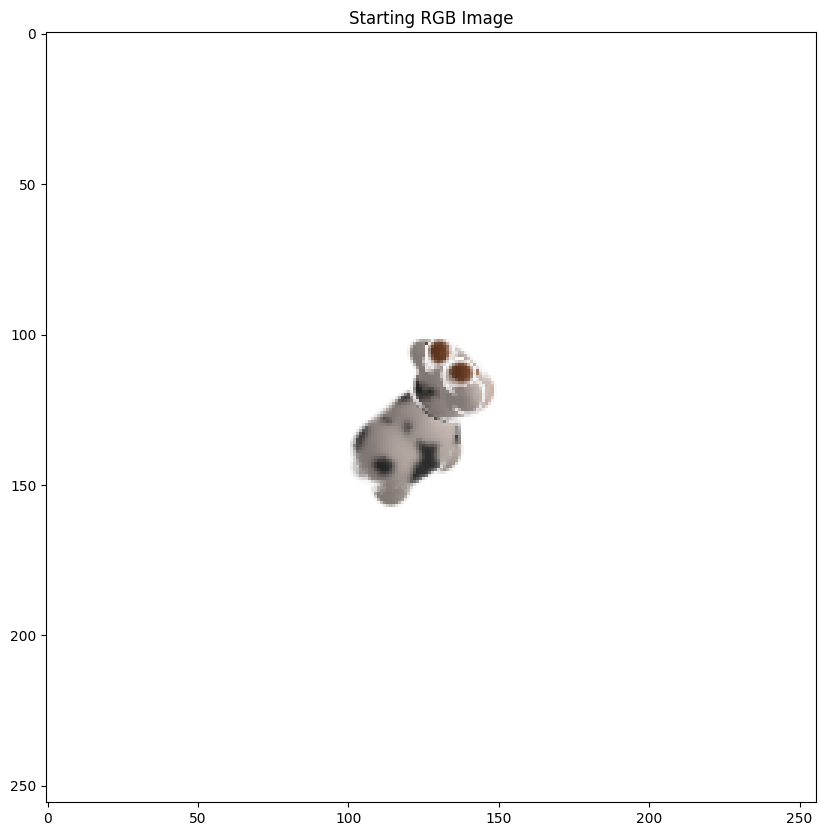

In [13]:
# Before running any optimization, 
# we will render an image to show the starting camera position

_, image_silhouette_init, image_rgb_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_silhouette_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, 'starting_silhouette.png'))

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb_init.cpu().detach().numpy().squeeze())
plt.grid(False)
plt.title("Starting RGB Image");
plt.savefig(os.path.join(output_dir, 'starting_rgb.png'))

In [14]:
# Running optimization iterations

for i in range(0, 200):
    if i%20 == 0:
        print('i = ', i)

    optimizer.zero_grad()
    loss, image_silhouette, image_textured = model()
    loss.backward()
    optimizer.step()

    plt.figure()
    plt.imshow(image_silhouette[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_silhouette_' + str(i) + '.png'))
    plt.close()

    plt.figure()
    plt.imshow(image_textured.detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_texture_' + str(i) + '.png'))
    plt.close()

    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)

    plt.figure()
    plt.imshow(image[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_silhouette_' + str(i) + '.png'))
    plt.close()

    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)

    plt.figure()
    plt.imshow(image[..., :3])
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_texture_' + str(i) + '.png'))
    plt.close()

    if loss.item() < 800:
        break

print('Finished')

i =  0
i =  20
i =  40
i =  60
i =  80
i =  100
i =  120
i =  140
i =  160
i =  180
Finished
